In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import CPTAC.Endometrial as en
import math

Welcome to the CPTAC data service package. Available datasets may be
viewed using CPTAC.list_data(). In order to access a specific data
set, import a CPTAC subfolder using either 'import CPTAC.Dataset' or
'from CPTAC import Dataset'.
******
Version: 0.2.7
******
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Acetylation Proteomics Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


In [2]:
#Get acetylation data
acetyl = en.get_acetylproteomics()

In [3]:
#Show a list of clinical attributes that can be tested with acetylation data
list(en.get_clinical().columns)

['Proteomics_Participant_ID',
 'Proteomics_Tumor_Normal',
 'Country',
 'Histologic_Grade_FIGO',
 'Myometrial_invasion_Specify',
 'Histologic_type',
 'Treatment_naive',
 'Tumor_purity',
 'Path_Stage_Primary_Tumor-pT',
 'Path_Stage_Reg_Lymph_Nodes-pN',
 'Clin_Stage_Dist_Mets-cM',
 'Path_Stage_Dist_Mets-pM',
 'tumor_Stage-Pathological',
 'FIGO_stage',
 'LVSI',
 'BMI',
 'Age',
 'Diabetes',
 'Race',
 'Ethnicity',
 'Gender',
 'Tumor_Site',
 'Tumor_Site_Other',
 'Tumor_Focality',
 'Tumor_Size_cm',
 'Num_full_term_pregnancies']

In [4]:
#Set desired attribute to variable 'clinical_attribute'
clinical_attribute = "Histologic_type"
clinical = en.get_clinical()

In [8]:
#Merge attribute with acetylation dataframe
clinical_and_acetylation = en.compare_clinical(omics_data = acetyl, clinical_col = clinical_attribute)
clinical_and_acetylation.head()
#clinical_and_acetylation.info()

idx,Histologic_type,A2M-K1168,A2M-K1176,A2M-K135,A2M-K145,A2M-K516,A2M-K664,A2M-K682,AACS-K391,AAGAB-K290,...,ZSCAN31-K215,ZSCAN32-K659,ZW10-K634,ZYX-K24,ZYX-K25,ZYX-K265,ZYX-K272,ZYX-K279,ZYX-K533,ZZZ3-K117
S001,Endometrioid,NaN,1.080,NaN,NaN,NaN,NaN,NaN,NaN,0.461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S002,Endometrioid,NaN,0.477,NaN,NaN,NaN,NaN,NaN,NaN,1.770,...,-0.104,-0.80300,NaN,-0.988,-0.343,-0.307,NaN,-0.0955,NaN,NaN
S003,Endometrioid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.815,...,NaN,NaN,NaN,-0.459,-1.170,NaN,NaN,-0.7050,0.089,NaN
S005,Endometrioid,NaN,-0.608,NaN,NaN,-0.919,NaN,NaN,NaN,NaN,...,-0.457,-0.00175,-0.33,NaN,-0.537,NaN,NaN,-0.3700,NaN,NaN
S006,Serous,NaN,1.630,NaN,2.4,NaN,NaN,1.26,NaN,0.205,...,NaN,0.41100,NaN,NaN,-0.358,NaN,NaN,-0.9700,NaN,NaN


In [6]:
#Show possible variations of Histologic_type
clinical_and_acetylation[clinical_attribute].unique()

array(['Endometrioid', 'Serous', nan], dtype=object)

In [20]:
#Make dataframes with only endometrioid and only serous data in order to compare 
endom = clinical_and_acetylation.loc[clinical_and_acetylation[clinical_attribute] == "Endometrioid"]
serous = clinical_and_acetylation.loc[clinical_and_acetylation[clinical_attribute] == "Serous"]
#Here is where we set the NaN values to "Non_Tumor"
clinical_and_acetylation[clinical_attribute] = clinical_and_acetylation[[clinical_attribute]].fillna(value="Non_Tumor")
#changed clinical_and_acetylation[[clinical_attribute]] =  to one bracket

In [21]:
num_sites_sufficient_data = 0
for num in range(1,len(serous.columns)):
    site = serous.columns[num]
    oneSite = serous[site]
    num_datapoints = oneSite.count() #Here we count the number of datapoints that we have at each site
    if num_datapoints >= 5:
        num_sites_sufficient_data += 1
print("Number of sites with sufficient data: ", num_sites_sufficient_data)
threshold = .05 / num_sites_sufficient_data
print("Multiple hypothesis adjusted threshold: ", threshold)

Number of sites with sufficient data:  3936
Multiple hypothesis adjusted threshold:  1.2703252032520325e-05


In [22]:
significantTests = []
significantSites = []
sigSiteCount = 0
p_value_index = 1
for num in range(1,len(clinical_and_acetylation.columns)):
    site = clinical_and_acetylation.columns[num]
    ttestRes = scipy.stats.ttest_ind(endom[site], serous[site])#This returns a tuple, with the t-statistic as 
    #the first value and the p-value as the second(index 1). We are interested in the p-value.
    if (ttestRes[p_value_index] <= threshold): #Check if there is a significant enough difference between data points
        sigSiteCount += 1
        significantTests.append(ttestRes)
        significantSites.append(site)
print("Number of sites with statistically significant difference between endometrioid and serous values: " + str(sigSiteCount))

Number of sites with statistically significant difference between endometrioid and serous values: 8


Ttest_indResult(statistic=5.991702127182772, pvalue=3.89570439448459e-08)


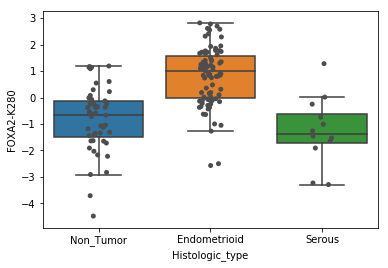

In [18]:
graphingSite = 'FOXA2-K280'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, showfliers = False, order = ["Non_Tumor", "Endometrioid", "Serous"])
sns.stripplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, color = '.3', order = ["Non_Tumor", "Endometrioid", "Serous"])
#color = '.3' makes the dots black

Ttest_indResult(statistic=-4.69713782197463, pvalue=9.090116393624886e-06)


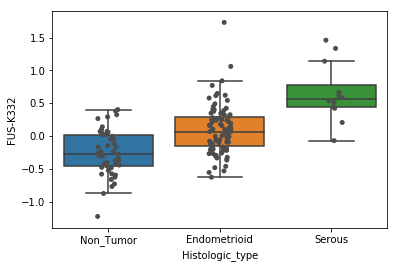

In [19]:
graphingSite = 'FUS-K332'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, showfliers = False, order = ["Non_Tumor", "Endometrioid", "Serous"])
sns.stripplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, color = '.3', order = ["Non_Tumor", "Endometrioid", "Serous"])